# MINE 4201 - Laboratorio 2 - Filtrado por contenido

Los sistemas de recomendación basados en contenido filtran contenido basado en la representación de items y el perfil del usuario. En este laboratorio trabajaremos con un conjunto de datos del sitio web [LibraryThing](https://https://www.librarything.com/).


## Preparación del entorno
Instale las librerias que vamos a utilizar e importelas en el ambiente de ejecución

In [1]:
!pip install scikit-learn
!pip install pandas
!pip install seaborn

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support



## Carga de archivos 

Copie el archivo del dataset en el entorno colab en la pestaña files (la carpeta en el menú de la izquierda), carguemos el csv en un dataframe de pandas y revisemos su contenido.

In [6]:
if not os.path.exists('DB-BOOK-content.csv') :
  raise ValueError('El archivo DB-BOOK-content.csv no fue encontrado en el path')
else:
  print("Los archivos han sido cargados")

Los archivos han sido cargados


In [7]:
df_dbbook = pd.read_csv('DB-BOOK-content.csv', sep = ';')
df_dbbook

,DBbook_userID,name,DBbook_ItemID,featureID,featureShortname,rate
0,1,"Contingency, Irony, and Solidarity",508,1066,/Category:1989_books,5
1,1,"Contingency, Irony, and Solidarity",508,2300,/Richard_Rorty,5
2,1,"Contingency, Irony, and Solidarity",508,2301,/Category:Works_about_Marcel_Proust,5
3,1,"Contingency, Irony, and Solidarity",508,2302,/Category:Books_by_Richard_Rorty,5
4,1,"Contingency, Irony, and Solidarity",508,2303,/Category:Books_about_irony,5
...,...,...,...,...,...,...
1439449,7255,The Catcher in the Rye,8010,3322,/Category:American_bildungsromans,3
1439450,7255,The Catcher in the Rye,8010,6746,/Category:1949_in_fiction,3
1439451,7255,The Catcher in the Rye,8010,9011,/J._D._Salinger,3
1439452,7255,The Catcher in the Rye,8010,10155,/Category:Novels_by_J._D._Salinger,3


Este dataset tiene un formato similar al que manejamos el taller pasado. Tiene una columna con el id del usuario, otra con el id del item y un rating. 

Cada rating esta presente varias veces, una por cada característica de los libros, revisemos por ejemplo las características del libro con ID 8010.

Se selecciona del dataframe las columnas name, featureID y featureShortname, la instruccion drop_duplicates nos deja solamente las columnas que no 

Nota: Para saber más de indexación de dataframes de pandas utilizando .loc hay una explicación en la [documentación](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html)



In [8]:
df_dbbook.loc[df_dbbook.DBbook_ItemID==8010,['DBbook_ItemID','name','featureID','featureShortname']].drop_duplicates()

,DBbook_ItemID,name,featureID,featureShortname
996,8010,The Catcher in the Rye,3,/Communication100033020
997,8010,The Catcher in the Rye,4,/Fiction106367107
998,8010,The Catcher in the Rye,5,/LiteraryComposition106364329
999,8010,The Catcher in the Rye,6,/Writing106362953
1000,8010,The Catcher in the Rye,7,/WrittenCommunication106349220
1001,8010,The Catcher in the Rye,11,/Novel106367879
1002,8010,The Catcher in the Rye,13,/Abstraction100002137
1003,8010,The Catcher in the Rye,228,/DebutNovels
1004,8010,The Catcher in the Rye,233,/Category:Debut_novels
1005,8010,The Catcher in the Rye,277,"/Category:Little,_Brown_and_Company_books"


Cada libro tiene features fueron extraidos de [DBpedia](https://wiki.dbpedia.org/). Dbpedia es una iniciativa para construir una representación de conceptos y relaciones mediante ontologías utilizando la información depositada en wikipedia. Más adelante vamos a utilizar DBPedia para otros talleres que aprovechan la información de la ontología de DBPedia, por ahora lo que tenemos es una representación de conjunto de palabras (o conceptos) para describir un item.  

## Creación de matriz documento-termino

En las siguientes líneas vamos a crear la matriz documento término, el primer paso es obtener en un dataframe los libros, los conceptos, y  los conceptos únicos por libro.

In [9]:
df_libros=df_dbbook.loc[:,['DBbook_ItemID','name']].drop_duplicates()
df_libros

,DBbook_ItemID,name
0,508,"Contingency, Irony, and Solidarity"
8,802,The Solitaire Mystery
26,889,Wise Blood
49,1367,The Bell Jar
72,1736,The Structure of Scientific Revolutions
...,...,...
1434966,2860,Practical Magic
1436627,3838,Destiny: A Chronicle of Deaths Foretold
1437751,5779,The Road to Omaha
1438719,3485,Kamikaze Girls


In [10]:
df_conceptos=df_dbbook.loc[:,['featureID','featureShortname']].drop_duplicates()
df_conceptos

,featureID,featureShortname
0,1066,/Category:1989_books
1,2300,/Richard_Rorty
2,2301,/Category:Works_about_Marcel_Proust
3,2302,/Category:Books_by_Richard_Rorty
4,2303,/Category:Books_about_irony
...,...,...
1438749,8790,/Category:Adventure_comedy_films
1438750,8791,/Category:Fantasy-comedy_films
1438752,8793,/Category:2004_Japanese_films
1438766,9393,/NovelsByDavidDrake


In [14]:
df_libros_concepto=df_dbbook.loc[:,['DBbook_ItemID','name','featureID','featureShortname']].drop_duplicates()
df_libros_concepto

,DBbook_ItemID,name,featureID,featureShortname
0,508,"Contingency, Irony, and Solidarity",1066,/Category:1989_books
1,508,"Contingency, Irony, and Solidarity",2300,/Richard_Rorty
2,508,"Contingency, Irony, and Solidarity",2301,/Category:Works_about_Marcel_Proust
3,508,"Contingency, Irony, and Solidarity",2302,/Category:Books_by_Richard_Rorty
4,508,"Contingency, Irony, and Solidarity",2303,/Category:Books_about_irony
...,...,...,...,...
1438763,3963,Queen of Demons,790,/1998Novels
1438764,3963,Queen of Demons,793,/Category:1998_novels
1438765,3963,Queen of Demons,4006,/David_Drake
1438766,3963,Queen of Demons,9393,/NovelsByDavidDrake


Se quiere obtener una martiz que tenga como filas cada uno de los libros, y como columnas cada uno de los conceptos, y en cada coordenada un 1 si esta presente el concepto y 0 de lo contrario. A esta operación se le conoce como pivot de una tabla.

La función [pivot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html) toma tres parámetros: la columna del dataframe original que va a tomar el índice de las filas del nuevo dataframe (index), la columna del dataframe original mediante la cual se van a generar las columnas (columns) y values los valores con los cuales se va a llenar el dataframe, en este caso  vamos a dejar momentaneamente el id del feature para indicar que existe.

Finalmente aplicamos la función [applymap](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.applymap.html) para modificar uno a uno los elementos de la matriz



In [15]:
df_matriz_libros_concepto=df_libros_concepto[['DBbook_ItemID','featureID']].drop_duplicates().pivot(index='DBbook_ItemID', columns='featureID', values='featureID')
#La función astype int8 nos permite reducir el uso de memoria al dejar matrices de enteros
df_matriz_libros_concepto=df_matriz_libros_concepto.applymap(np.sign).fillna(0).astype('int8')
df_matriz_libros_concepto

featureID,1,2,3,4,5,6,7,8,9,10,...,13992,13993,13994,13995,13996,13997,13998,13999,14000,14001
DBbook_ItemID,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8164,0,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8166,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
df_matriz_libros_concepto.shape

(6164, 12246)

En la siguiente celda se está aplicando la función [sumatoria](https://www.geeksforgeeks.org/python-pandas-dataframe-sum/) por eje al dataframe anterior, por defecto el eje es 0, por lo que generará una Serie (vector) del tamaño de las columnas y por cada columna calculará la sumatoria

In [17]:
help(pd.DataFrame.sum)

Help on function sum in module pandas.core.frame:

sum(self, axis=None, skipna=None, level=None, numeric_only=None, min_count=0, **kwargs)
    Return the sum of the values for the requested axis.
    
    This is equivalent to the method ``numpy.sum``.
    
    Parameters
    ----------
    axis : {index (0), columns (1)}
        Axis for the function to be applied on.
    skipna : bool, default True
        Exclude NA/null values when computing the result.
    level : int or level name, default None
        If the axis is a MultiIndex (hierarchical), count along a
        particular level, collapsing into a Series.
    numeric_only : bool, default None
        Include only float, int, boolean columns. If None, will attempt to use
        everything, then use only numeric data. Not implemented for Series.
    min_count : int, default 0
        The required number of valid values to perform the operation. If fewer than
        ``min_count`` non-NA values are present the result will be N

In [18]:
series_suma=df_matriz_libros_concepto.sum()
series_suma

featureID
1           6
2         225
3        2766
4        2672
5        2674
         ... 
13997       1
13998       1
13999       1
14000       1
14001       1
Length: 12246, dtype: int64

El objeto series_suma no es un dataframe sino un objeto tipo Series, que es un arreglo. Un dataframe puede ser visto como una concatenación de varios objetos de tipo Series

In [26]:
type(series_suma)

pandas.core.series.Series

**Interprete las siguientes figuras y diga qué quieren decir en términos del número de items y de características asignadas a los items**

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


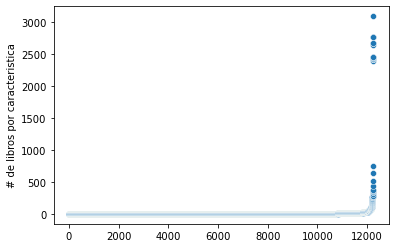

In [77]:
sns.scatterplot(range(0,len(series_suma)) ,series_suma.sort_values())
plt.ylabel('# de libros por caracteristica')
plt.show()

Hay una feature que esta disponible para 3000 libros.

In [50]:
series_suma_2=df_matriz_libros_concepto.sum(axis=1)
series_suma_2

DBbook_ItemID
1       23
2       20
3       36
5       23
7       22
        ..
8164    23
8166    13
8167    17
8168    22
8169    25
Length: 6164, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


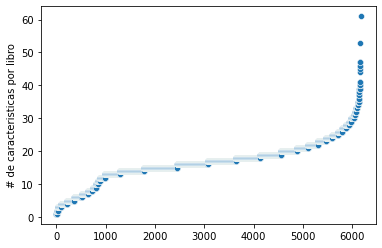

In [79]:
sns.scatterplot(range(0,len(series_suma_2)) ,series_suma_2.sort_values() )
plt.ylabel('# de caracteristicas por libro')
plt.show()

Esta grafica nos muestra cuantos libros tienen disponibles x caracteristicas.

In [72]:
df_libros_concepto[df_libros_concepto.featureID.isin(series_suma_2[series_suma_2 > series_suma_2.quantile(0.75)].index)]

,DBbook_ItemID,name,featureID,featureShortname
8,802,The Solitaire Mystery,3,/Communication100033020
10,802,The Solitaire Mystery,5,/LiteraryComposition106364329
12,802,The Solitaire Mystery,7,/WrittenCommunication106349220
15,802,The Solitaire Mystery,127,/Fantasy
26,889,Wise Blood,3,/Communication100033020
...,...,...,...,...
1438753,3963,Queen of Demons,3,/Communication100033020
1438755,3963,Queen of Demons,5,/LiteraryComposition106364329
1438757,3963,Queen of Demons,7,/WrittenCommunication106349220
1438762,3963,Queen of Demons,556,/Category:American_fantasy_novels


In [61]:
series_suma_2.describe()

count    6164.000000
mean       16.677969
std         6.224735
min         1.000000
25%        14.000000
50%        17.000000
75%        20.000000
max        61.000000
dtype: float64

# Cálculo de matriz tf-idf

La matriz df_matriz_libros_concepto hasta el momento tiene en cada coordenada la presencia o ausencia de la característica que describe el atributo, este sería el término $\text{tf}$ de la siguiente fórmula donde $i$ es un término o palabra y $d$ es un documento.

$\text{tfidf}_{i,d} = \text{tf}_{i,d} \cdot \text{idf}_{i}$

El Inverse Document Frequency esta definido como:

$\text{idf}_{i,d} = \log \frac{N}{\text{df}_{i}}$

Donde $\text{df}_{t}$ es el número de documentos en los que aparece el término $i$ y N el número total de documentos 



En python es posible operar vectores con escalares directamente, gracias a que por debajo python genera operaciones entre arreglos cuando operamos con un escalar mediante la operación de [broadcasting](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html) Por ejemplo, el anterior arreglo se puede dividir entre 6, por debajo python genera un arreglo del mismo tamaño y realiza la operación elemento a elemento

In [82]:
series_suma/6

featureID
1          1.000000
2         37.500000
3        461.000000
4        445.333333
5        445.666667
            ...    
13997      0.166667
13998      0.166667
13999      0.166667
14000      0.166667
14001      0.166667
Length: 12246, dtype: float64

En las siguientes celdas, cree un objeto tipo series llamado df_idf, que contiene el IDF de cada atributo. Puede utilizar la función [np.log2](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log2.html) de numpy

In [93]:
df_idf= np.log(len(df_libros)/series_suma)
df_idf

featureID
1        6.934722
2        3.310381
3        0.801324
4        0.835899
5        0.835150
           ...   
13997    8.726481
13998    8.726481
13999    8.726481
14000    8.726481
14001    8.726481
Length: 12246, dtype: float64

Si df_idf fue calculado correctamente, la siguiente instrucción multiplicará cada fila del dataframe elemento por elemento (element-wise) por la serie que contiene el IDF

In [94]:
df_matriz_tf_idf=df_matriz_libros_concepto.multiply(df_idf, axis=1)
df_matriz_tf_idf

featureID,1,2,3,4,5,6,7,8,9,10,...,13992,13993,13994,13995,13996,13997,13998,13999,14000,14001
DBbook_ItemID,,,,,,,,,,,,,,,,,,,,,
1,6.934722,3.310381,0.801324,0.835899,0.83515,0.803133,0.803133,4.719148,4.876334,6.64704,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,6.934722,3.310381,0.801324,0.835899,0.83515,0.803133,0.803133,0.000000,4.876334,6.64704,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,4.719148,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8164,0.000000,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
8166,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
8167,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


En el siguiente mapa de calor se observa el tf_idf de los items representados en las 300 características con mayor frecuencia.

In [117]:
df_matriz_tf_idf.loc[:,series_suma.nlargest(300).index]

featureID,13,3,6,7,5,4,11,65,59,60,...,1637,2214,2227,2228,2230,2702,447,496,1299,1507
DBbook_ItemID,,,,,,,,,,,,,,,,,,,,,
1,0.690879,0.801324,0.803133,0.803133,0.83515,0.835899,0.850602,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.690879,0.801324,0.803133,0.803133,0.83515,0.835899,0.850602,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.690879,0.801324,0.803133,0.803133,0.83515,0.835899,0.850602,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.690879,0.801324,0.803133,0.803133,0.83515,0.835899,0.850602,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.690879,0.801324,0.803133,0.803133,0.83515,0.835899,0.850602,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8164,0.690879,0.801324,0.803133,0.803133,0.83515,0.835899,0.850602,0.000000,0.000000,0.000000,...,5.260745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8166,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.918565,0.918971,0.918971,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8167,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.918565,0.918971,0.918971,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


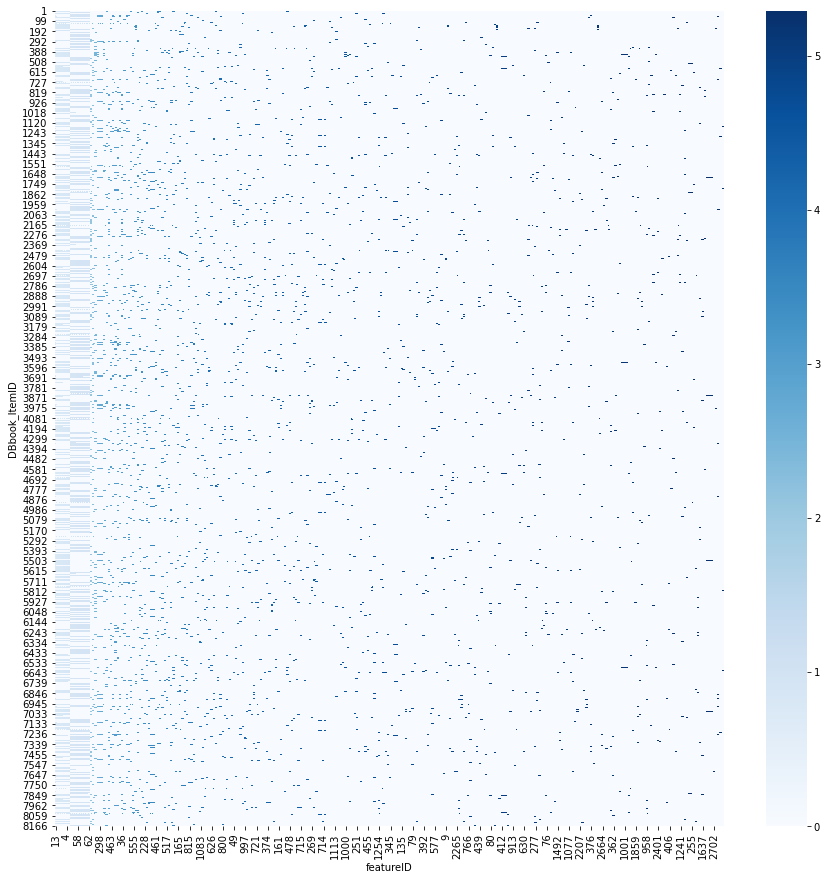

In [104]:
plt.rcParams["figure.figsize"] = (15,15)
sns.heatmap(df_matriz_tf_idf.loc[:,series_suma.nlargest(300).index], cmap="Blues", vmin=0)
plt.show()

**¿Qué puede interpretar sobre la figura anterior? 
Encuentre los nombres de las características más frecuentes**

El mapa de calor es la representación gráfica de la matriz, y esta mostrando la variacion del tf_idf de cada caracteristica para cada libro. Ademas, la escala de 1 a 5 nos indica que tan frecuentemente aparece una feature especifica en el numero total de libros. Así los valores cercanos a 0 indican mayor frecuencia, y los valores mas grandes indican menor frecuencia.

In [102]:
print('Esta tabla muestra el nombre de las 300 caracteristicas mas frecuentes.')
df_conceptos[df_conceptos.featureID.isin(series_suma.nlargest(300).index)]

Esta tabla muestra el nombre de las 300 caracteristicas mas frecuentes.


,featureID,featureShortname
8,3,/Communication100033020
9,4,/Fiction106367107
10,5,/LiteraryComposition106364329
11,6,/Writing106362953
12,7,/WrittenCommunication106349220
...,...,...
13537,1632,/Category:Children's_fiction_books
14085,902,/AmericanHorrorNovels
15043,197,/Category:1975_novels
15636,953,/BroadwayPlays


# Selección de características

Una vez realizado el proceso de indexamiento, se puede realizar el proceso de selección de características. 

En este momento contamos con más de 12 mil conceptos. ¿Con cuántos vale la pena crear los modelos de filtrado?

El paso más simple es filtrar las características con baja frecuencia dentro del dataset

In [118]:
series_suma.describe()

count    12246.000000
mean         8.394823
std         95.183540
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       3089.000000
dtype: float64

**¿Qué puede decir sobre la distribución de frecuencia de las características en los items? ¿Vale la pena tener todas las características que tenemos actualmente?**

.
**Retire de la matriz df_matrix_tf_idf las columnas que representan a los items que tienen menos de 3 items asociados**

In [120]:
# Se filtra la serie por aquellos que tienen al menos 3 
series_suma[series_suma>=3]

featureID
1           6
2         225
3        2766
4        2672
5        2674
         ... 
13204       5
13549       3
13627       3
13920       5
13922       5
Length: 3894, dtype: int64

In [121]:
df_matriz_tf_idf= df_matriz_tf_idf.loc[:,series_suma[series_suma>=3].index]

In [122]:
df_matriz_tf_idf

featureID,1,2,3,4,5,6,7,8,9,10,...,12919,12995,12997,13045,13046,13204,13549,13627,13920,13922
DBbook_ItemID,,,,,,,,,,,,,,,,,,,,,
1,6.934722,3.310381,0.801324,0.835899,0.83515,0.803133,0.803133,4.719148,4.876334,6.64704,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.934722,3.310381,0.801324,0.835899,0.83515,0.803133,0.803133,0.000000,4.876334,6.64704,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,4.719148,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8164,0.000000,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8166,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8167,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Para las siguientes estrategias de selección de características, tenemos que aplicar técnicas supervisadas (que conocen la clase a predecir o lo que se quiere pronosticar), para esto tenemos que retomar nuestro dataset original de interacciones entre usuarios e items para asignar la etiqueta (le gustó/ no le gustó)

In [123]:
# Recordemos como es el dataset original.
df_dbbook.head(20)

,DBbook_userID,name,DBbook_ItemID,featureID,featureShortname,rate
0,1,"Contingency, Irony, and Solidarity",508,1066,/Category:1989_books,5
1,1,"Contingency, Irony, and Solidarity",508,2300,/Richard_Rorty,5
2,1,"Contingency, Irony, and Solidarity",508,2301,/Category:Works_about_Marcel_Proust,5
3,1,"Contingency, Irony, and Solidarity",508,2302,/Category:Books_by_Richard_Rorty,5
4,1,"Contingency, Irony, and Solidarity",508,2303,/Category:Books_about_irony,5
5,1,"Contingency, Irony, and Solidarity",508,2304,/Category:Cambridge_University_Press_books,5
6,1,"Contingency, Irony, and Solidarity",508,2305,/Category:Cognitive_science_literature,5
7,1,"Contingency, Irony, and Solidarity",508,2306,/Category:Ethics_books,5
8,1,The Solitaire Mystery,802,3,/Communication100033020,4
9,1,The Solitaire Mystery,802,4,/Fiction106367107,4


Creemos un dataframe para crear un dataset de un sistema de recomendación como el visto en el laboratorio pasado (una única interacción de tipo usuario, item y rating)

In [124]:
df_all_interactions=df_dbbook[['DBbook_userID','DBbook_ItemID','rate']].drop_duplicates()
df_all_interactions

,DBbook_userID,DBbook_ItemID,rate
0,1,508,5
8,1,802,4
26,1,889,5
49,1,1367,5
72,1,1736,5
...,...,...,...
1439370,7255,6871,3
1439392,7255,7227,3
1439401,7255,7471,3
1439416,7255,7472,4


Para asignar una clase, se binarizan los ratings. Una regla simple es calcular el rating promedio por persona. Todo lo que esté por debajo del promedio se clasifica como no le gusta, igual o por encima es si le gusta.

In [126]:
df_user_mean=df_all_interactions.groupby('DBbook_userID')['rate'].mean().reset_index()
df_user_mean.columns=['DBbook_userID','mean']
df_user_mean

,DBbook_userID,mean
0,1,4.545455
1,2,4.250000
2,3,3.684211
3,4,3.571429
4,5,4.181818
...,...,...
6176,7251,3.800000
6177,7252,3.230769
6178,7253,4.000000
6179,7254,4.222222


**Realice un merge entre df_all_interactions y df_user_mean, asignando su resultado a df_all_interactions.
Cree una nueva columna en el dataframe df_all_interactions llamada 'class' con True si el rating del usuario es mayor o igual a su promedio**

[Documentación pandas merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html)

[Tutorial creación de columnas a partir del valor de otras](https://thispointer.com/python-pandas-how-to-add-new-columns-in-a-dataframe-using-or-dataframe-assign/)

In [128]:

df_all_interactions=df_all_interactions.merge(df_user_mean, how = 'left', on = 'DBbook_userID')

In [143]:

df_all_interactions['class'] = np.where(df_all_interactions['rate'] >= df_all_interactions['mean'], True, False)

In [144]:
df_all_interactions

,DBbook_userID,DBbook_ItemID,rate,mean,class
0,1,508,5,4.545455,True
1,1,802,4,4.545455,False
2,1,889,5,4.545455,True
3,1,1367,5,4.545455,True
4,1,1736,5,4.545455,True
...,...,...,...,...,...
75537,7255,6871,3,3.166667,False
75538,7255,7227,3,3.166667,False
75539,7255,7471,3,3.166667,False
75540,7255,7472,4,3.166667,True


Por último, se procede a partir el dataset en entrenamiento y test. Se utiliza de la librería sklearn la función [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

Esta recibe como parámetro el dataset a partir, el porcentaje para test y un parámetro que indica la variable por la cual estratificar la partición, en este caso quisieramos que las interacciones en test sean de usuarios que vimos en train, por lo tanto se deja estratificado por usuario.

In [145]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, **options)
    Split arrays or matrices into random train and test subsets
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. If ``train_size`` is also Non

In [147]:
#Para garantizar reproducibilidad en resultados
seed = 10
random.seed(seed)
np.random.seed(seed)
df_all_interactions_train, df_all_interactions_test =train_test_split(df_all_interactions, test_size=0.2, stratify=df_all_interactions['DBbook_userID'])

In [148]:
df_all_interactions_train

,DBbook_userID,DBbook_ItemID,rate,mean,class
24833,2370,2953,4,4.052632,False
56625,5431,4173,5,4.250000,True
10105,964,8079,2,3.333333,False
50749,4875,6704,5,4.500000,True
68974,6618,8169,3,3.333333,False
...,...,...,...,...,...
64065,6144,5377,4,3.846154,True
69813,6703,6350,2,2.857143,False
40591,3886,8010,4,3.695652,True
41668,3995,331,3,2.941176,True


In [149]:
df_all_interactions_test

,DBbook_userID,DBbook_ItemID,rate,mean,class
11939,1124,1578,4,3.272727,True
56050,5372,7493,4,3.823529,True
19022,1806,4048,2,3.166667,False
43618,4198,1575,2,2.777778,False
68239,6549,4109,3,3.714286,False
...,...,...,...,...,...
33,3,7231,4,3.684211,True
64551,6194,4697,3,4.000000,False
55801,5350,5046,5,4.777778,True
33391,3187,2646,3,3.500000,False


In [150]:
df_all_interactions_train.DBbook_userID.value_counts()

4242    19
2678    19
3083    19
5727    19
664     19
        ..
5468     4
1893     4
2990     4
5037     4
5801     4
Name: DBbook_userID, Length: 6181, dtype: int64

In [151]:
df_all_interactions_test.DBbook_userID.value_counts()

2049    5
6489    5
3639    5
6337    5
3583    5
       ..
3051    1
7117    1
5076    1
986     1
7169    1
Name: DBbook_userID, Length: 6181, dtype: int64

In [153]:
df_conteos_usuario_train_test=pd.concat([df_all_interactions_train.DBbook_userID.value_counts(),df_all_interactions_test.DBbook_userID.value_counts()],axis=1)
df_conteos_usuario_train_test.columns=['train_count','test_count']
df_conteos_usuario_train_test

,train_count,test_count
1,9,2
2,6,2
3,15,4
4,11,3
5,9,2
...,...,...
7251,4,1
7252,10,3
7253,14,4
7254,7,2


In [154]:
df_conteos_usuario_train_test

,train_count,test_count
1,9,2
2,6,2
3,15,4
4,11,3
5,9,2
...,...,...
7251,4,1
7252,10,3
7253,14,4
7254,7,2


In [155]:
df_conteos_usuario_train_test.nlargest(500,'test_count')

,train_count,test_count
9,19,5
23,19,5
29,17,5
68,19,5
69,18,5
...,...,...
642,18,4
649,17,4
658,16,4
665,17,4


**Chi-cuadrado**

La selección de características mediante la prueba [chi-cuadrado](https://en.wikipedia.org/wiki/Chi-squared_test) nos dice si la diferencia observada entre las frecuencias de co-ocurrencia de dos variables es significativa. La idea es seleccionar características que más ayuden a discriminar la clase objetivo observando la frecuencia en la que ocurren juntas. 

La librería sklearn permite identificar la importancia de cada una de las variables utilizando el método [chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html)

In [156]:
help(chi2)

Help on function chi2 in module sklearn.feature_selection._univariate_selection:

chi2(X, y)
    Compute chi-squared stats between each non-negative feature and class.
    
    This score can be used to select the n_features features with the
    highest values for the test chi-squared statistic from X, which must
    contain only non-negative features such as booleans or frequencies
    (e.g., term counts in document classification), relative to the classes.
    
    Recall that the chi-square test measures dependence between stochastic
    variables, so using this function "weeds out" the features that are the
    most likely to be independent of class and therefore irrelevant for
    classification.
    
    Read more in the :ref:`User Guide <univariate_feature_selection>`.
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Sample vectors.
    
    y : array-like of shape (n_samples,)
        Target vector (class labels).


En filtrado por contenido, se arma un modelo por usuario. Por ahora vamos a escoger las características más importantes para el primer usuario del dataset de test

In [157]:
#Debería dar 1124
primer_usuario_id=df_all_interactions_test.iloc[0]['DBbook_userID']
primer_usuario_id

1124

Obtengamos los ids de los items con los que ha interactuado y su opinion

In [158]:
df_temporal_usuario=df_all_interactions_train.loc[df_all_interactions_train.DBbook_userID==1124,['DBbook_ItemID','class']]
df_temporal_usuario

,DBbook_ItemID,class
11942,3155,True
11947,5736,True
11946,4799,False
11937,1292,False
11944,4108,False
11945,4614,False
11941,3006,True
11940,1970,True
11938,1391,False


Peguemos a este dataframe la representación vectorial de tf_idf por el id del item, en la matriz es el índice de las filas

In [159]:
df_temporal_usuario=df_temporal_usuario.merge(df_matriz_tf_idf, how='left', left_on='DBbook_ItemID', right_index=True)
df_temporal_usuario

,DBbook_ItemID,class,1,2,3,4,5,6,7,8,...,12919,12995,12997,13045,13046,13204,13549,13627,13920,13922
11942,3155,True,0.0,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11947,5736,True,0.0,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11946,4799,False,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11937,1292,False,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11944,4108,False,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11945,4614,False,0.0,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11941,3006,True,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11940,1970,True,0.0,3.310381,0.801324,0.835899,0.83515,0.803133,0.803133,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11938,1391,False,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Este dataframe representa los datos de entrenamiento del modelo para predicción de una clase binaria (class True es le gusta, class False es no le gusta)

In [161]:
#vamos a indexar solamente las columnas que son características, la prueba chi2 lo compara todas las características contra la clase objetivo
features=df_matriz_tf_idf.columns
features

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            12919, 12995, 12997, 13045, 13046, 13204, 13549, 13627, 13920,
            13922],
           dtype='int64', name='featureID', length=3894)

In [163]:
pesos_chi2, pval= chi2(df_temporal_usuario[features],df_temporal_usuario['class'])

In [164]:
#La prueba puede arrojar nan
pesos_chi2

array([       nan, 4.13797599, 1.21200207, ...,        nan,        nan,
              nan])

In [165]:
pval

array([       nan, 0.04193128, 0.27093598, ...,        nan,        nan,
              nan])

In [166]:
# LLenamos con peso 0 los que no se pudieron calcular
pesos_chi2=np.nan_to_num(pesos_chi2)
pesos_chi2

array([0.        , 4.13797599, 1.21200207, ..., 0.        , 0.        ,
       0.        ])

Se crea una máscara de indexación con los valores que son positivos según la prueba

In [167]:
pesos_chi2_mask=pesos_chi2>0

In [168]:
pesos_chi2_mask

array([False,  True,  True, ..., False, False, False])

In [169]:
features[pesos_chi2_mask]

Int64Index([    2,     3,     4,     5,     6,     7,    11,    13,    22,
               30,
            ...
             5507,  5685,  6095,  6096,  6097,  6716,  8656,  8658,  8659,
            10004],
           dtype='int64', name='featureID', length=119)

El siguiente sería el resultado, se recortaron las columnas de pesos del usuario, dejando 119 features.

In [170]:
df_temporal_usuario.loc[:,features[pesos_chi2_mask]]

featureID,2,3,4,5,6,7,11,13,22,30,...,5507,5685,6095,6096,6097,6716,8656,8658,8659,10004
11942,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.850602,0.690879,0.000000,0.000000,...,6.328586,6.934722,0.000000,0.000000,0.000000,6.529257,0.00000,0.000000,0.000000,0.000000
11947,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.850602,0.690879,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,7.627869
11946,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
11937,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
11944,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.103745,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.64704,6.780571,6.780571,0.000000
11945,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.850602,0.690879,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
11941,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.690879,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
11940,3.310381,0.801324,0.835899,0.83515,0.803133,0.803133,0.850602,0.690879,5.171133,0.000000,...,0.000000,0.000000,7.627869,7.627869,7.627869,0.000000,0.00000,0.000000,0.000000,0.000000
11938,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


In [171]:
del df_temporal_usuario

**Complete el código de la siguiente celda, el objetivo es crear un diccionario donde la llave es el id del usuario y el valor es un arreglo con los features seleccionados para el usuario**

El proceso que implementamos no esta optimizado, por lo que vamos a armar el modelo solamente para los 500 usuarios con más ratings en el dataset de test.


In [173]:
diccionario_usuarios_features={}
# 500 usuarios con más ratings en test
unique_users_test=df_conteos_usuario_train_test.nlargest(500,'test_count').index
i=0
print(unique_users_test.shape)
for user in unique_users_test:
  if not user in diccionario_usuarios_features:
    df_temporal_usuario=df_all_interactions_train.loc[df_all_interactions_train.DBbook_userID==user,['DBbook_ItemID','class']]
    
    df_temporal_usuario=df_temporal_usuario.merge(df_matriz_tf_idf, how = 'left', left_on = 'DBbook_ItemID', right_index = True)
   
    pesos_chi2, pval=  chi2(df_temporal_usuario[features],df_temporal_usuario['class'])
    pesos_chi2=np.nan_to_num(pesos_chi2)
    pesos_chi2_mask=pesos_chi2>0
    features_usuario=features[pesos_chi2_mask]
    diccionario_usuarios_features[user]=features_usuario
    i=i+1
    if i%50==0:
      print(i)  
    del df_temporal_usuario






(500,)
50
100
150
200
250
300
350
400
450
500


In [174]:
len(diccionario_usuarios_features)

500

In [176]:
diccionario_usuarios_features.keys()

dict_keys([9, 23, 29, 68, 69, 107, 118, 144, 158, 175, 188, 189, 196, 201, 206, 209, 212, 215, 239, 248, 251, 254, 321, 351, 362, 401, 406, 408, 409, 430, 509, 511, 524, 547, 581, 617, 627, 643, 647, 651, 661, 664, 669, 676, 681, 689, 701, 734, 740, 765, 768, 774, 784, 854, 857, 872, 876, 887, 919, 921, 931, 938, 976, 1001, 1019, 1021, 1036, 1044, 1076, 1084, 1099, 1103, 1114, 1176, 1199, 1206, 1214, 1247, 1294, 1301, 1306, 1341, 1343, 1345, 1362, 1415, 1423, 1438, 1483, 1508, 1512, 1525, 1537, 1541, 1547, 1549, 1553, 1563, 1580, 1589, 1600, 1609, 1640, 1660, 1671, 1690, 1715, 1722, 1726, 1728, 1754, 1783, 1858, 1903, 1928, 1934, 1955, 1956, 1965, 2004, 2017, 2041, 2049, 2050, 2069, 2089, 2097, 2103, 2107, 2108, 2134, 2137, 2147, 2159, 2160, 2172, 2184, 2185, 2193, 2200, 2208, 2224, 2230, 2253, 2258, 2262, 2286, 2287, 2288, 2313, 2318, 2329, 2345, 2429, 2433, 2455, 2474, 2490, 2524, 2539, 2610, 2643, 2678, 2682, 2689, 2701, 2705, 2730, 2742, 2757, 2812, 2840, 2847, 2852, 2873, 2877, 28

Otro criterio que puede ser usado es [Mutual Information](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif) 

# Modelo de recomendación y evaluación

Una vez seleccionadas las características por usuario, se puede usar el dataset de entrenamiento para aprender un modelo de clasificación binaria y probarlo sobre test.

Uno de los modelos que puede ser utilizado es el [clasificador por vecinos más cercanos](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

Cada usuario tiene unas instancias representadas en un espacio vectorial del tamaño de las características seleccionadas anteriormente. Para una nueva instancia (predicción) se mira cuáles son los k vecinos más cercanos a ese dato nuevo y se predice la clase mayoritaria dentro del grupo de los vecinos. Observe el siguiente ejemplo. 

In [178]:
%%html
<iframe src="https://es.wikipedia.org/wiki/K_vecinos_m%C3%A1s_pr%C3%B3ximos#/media/Archivo:KnnClassification.svg" width="1200" height="600"></iframe>

Tomemos como ejemplo el usuario 679, armemos su conjunto de entrenamiento. Note que se estan seleccionando solamente los features calculados en el punto anterior

In [179]:
features_usuario_679=diccionario_usuarios_features[679]
df_temporal_usuario_train=df_all_interactions_train.loc[df_all_interactions_train.DBbook_userID==679,['DBbook_ItemID','class']]
df_temporal_usuario_train=df_temporal_usuario_train.merge(df_matriz_tf_idf[features_usuario_679], how='left', left_on='DBbook_ItemID', right_index=True)
df_temporal_usuario_train

,DBbook_ItemID,class,2,3,4,5,6,7,11,12,...,6355,6356,6357,6358,6359,6840,6841,7365,7995,7996
7075,7483,True,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7060,1501,False,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.850602,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7065,2366,True,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.850602,0.000000,...,5.836109,7.627869,5.359185,5.893268,7.627869,0.000000,0.00000,0.000000,0.000000,0.000000
7063,1691,True,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.850602,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7071,5021,False,3.310381,0.801324,0.835899,0.83515,0.803133,0.803133,0.850602,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7066,2676,False,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.850602,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,7.627869,0.000000,0.000000
7058,222,False,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.850602,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7074,6807,False,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.850602,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,7.627869,0.000000,0.000000
7068,3594,False,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.850602,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,7.627869,0.000000,0.000000
7061,1505,False,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.850602,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


Armamos de igual forma el conjunto de test

In [180]:
df_temporal_usuario_test=df_all_interactions_test.loc[df_all_interactions_test.DBbook_userID==679,['DBbook_ItemID','class']]
df_temporal_usuario_test=df_temporal_usuario_test.merge(df_matriz_tf_idf[features_usuario_679], how='left', left_on='DBbook_ItemID', right_index=True)
df_temporal_usuario_test

,DBbook_ItemID,class,2,3,4,5,6,7,11,12,...,6355,6356,6357,6358,6359,6840,6841,7365,7995,7996
7072,5325,True,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7073,5424,True,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7070,4581,True,0.000000,0.801324,0.835899,0.83515,0.803133,0.803133,0.850602,0.0,...,5.836109,0.0,5.359185,5.893268,0.0,0.0,0.0,0.0,0.0,0.0
7062,1683,True,3.310381,0.801324,0.835899,0.83515,0.803133,0.803133,0.850602,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Utilizaremos la clase [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) de scikit-learn para hacer la predicción de los datos del conjunto de test. El modelo tiene 3 métodos principales. El constructor permite inicializar el k a usar, la métrica entre otros; fit sirve para darle los datos de entrenamiento base al modelo; y predict para predecir los datos que se le pasan.

In [181]:
#Con esta configuración se utilizan los 3 vecinos más cercanos, con distancia euclidiana
knn_clasif=KNeighborsClassifier(3)

In [182]:
# Fit recibe la matriz de entrenamiento y la clase objetivo
knn_clasif.fit(df_temporal_usuario_train[features_usuario_679], df_temporal_usuario_train['class'])

KNeighborsClassifier(n_neighbors=3)

In [183]:
# llamamos predict sobre  los test , creando una nueva columna en el dataframe de test
df_temporal_usuario_test['predict']=knn_clasif.predict(df_temporal_usuario_test[features_usuario_679])

In [184]:
df_temporal_usuario_test[['DBbook_ItemID','class','predict']].merge(df_libros, how='left', on='DBbook_ItemID')

,DBbook_ItemID,class,predict,name
0,5325,True,False,Morality for Beautiful Girls
1,5424,True,False,Tears of the Giraffe
2,4581,True,False,Dragonsong
3,1683,True,True,Shadows in Bronze


**En las siguientes celdas realice hipótesis sobre por qué falló la clasificación para estos items y por qué funcionó para los otros, revise los conceptos seleccionados para el usuario y los asociados a los items**

Finalmente, la librería sklearn tiene diferentes métricas de evaluación de clasificación. En particular podemos calcular la matriz de confusión de la clasificación utilizando la función [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), y el cálculo de las métricas precision, recall, y f1 con la función [precision_recall_fscore_support](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)

In [185]:
tn, fp, fn, tp = confusion_matrix(df_temporal_usuario_test['class'],df_temporal_usuario_test['predict'], labels=[False,True]).ravel()

(tn, fp, fn, tp)

(0, 0, 3, 1)

In [189]:
confusion_matrix(df_temporal_usuario_test['class'],df_temporal_usuario_test['predict'], labels=[False,True])

array([[0, 0],
       [3, 1]], dtype=int64)

In [186]:
precision_recall_fscore_support(df_temporal_usuario_test['class'],df_temporal_usuario_test['predict'], pos_label=True, average='binary')

(1.0, 0.25, 0.4, None)

**Ejercicio: Realice las predicciones binarias para los usuarios en el conjunto de test a los que se les hizo la selección de características, mida la precisión, el recall y f_score de su modelo con las predicciones realizadas y ajústelo cambiando el k**

In [ ]:
df_usuario_train_intento = df_all_interactions_train.loc[df_all_interactions_train.DBbook_userID.isin(list(diccionario_usuarios_features.keys())),['DBbook_ItemID','class']]
df_temporal_usuario_train=df_temporal_usuario_train.merge(df_matriz_tf_idf[features_usuario_679], how='left', left_on='DBbook_ItemID', right_index=True)
df_temporal_usuario_train

In [193]:
df_usuario_train_intento = df_all_interactions_train.loc[df_all_interactions_train.DBbook_userID.isin(list(diccionario_usuarios_features.keys())),['DBbook_ItemID','class']]
df_usuario_train_intento = df_usuario_train_intento.merge(df_matriz_tf_idf[features_usuario_679], how='left', left_on='DBbook_ItemID', right_index=True)

,DBbook_ItemID,class
15647,788,True
58135,7286,False
49478,3486,True
49247,206,False
58942,7493,False
...,...,...
6512,1386,False
63871,2744,False
5801,7605,False
40591,8010,True
